# Imports

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import bcolz
from importlib import reload
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import decode_predictions
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from keras.preprocessing import image

Using Theano backend.


# Calculate average image

In [ ]:
gen = ImageDataGenerator()
batches = gen.flow_from_directory('../data/all', 
                                  target_size=(800, 1280), 
                                  batch_size=50, 
                                  class_mode=None,
                                  shuffle=False)


sum_img = np.zeros((3, 800, 1280))
for i in range(batches.n // 50):
    print('Iteration ', i)
    data = next(batches)
    for h in range(data.shape[0]):
        sum_img += data[h]
    
avg_img = sum_img / ((batches.n // 50) * 50)

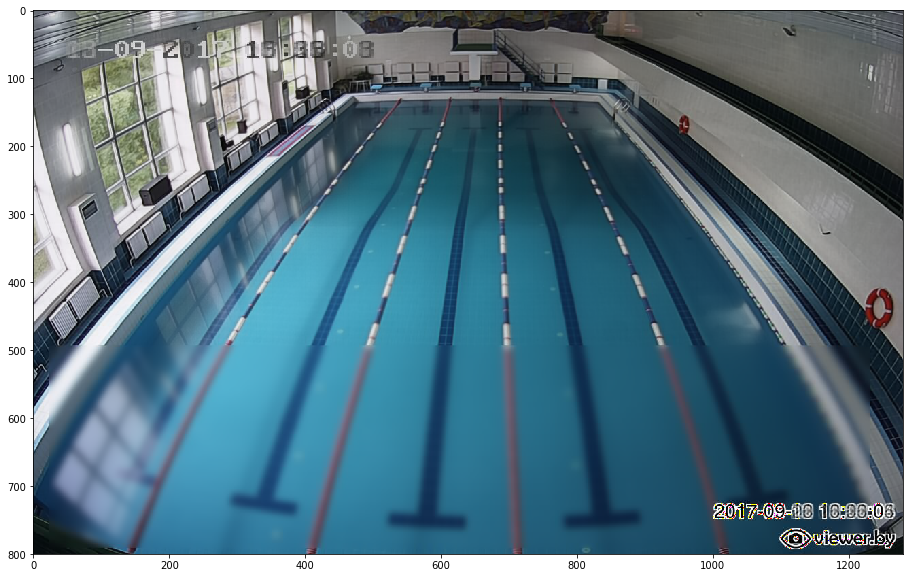

In [5]:
plt.figure(figsize = (25,10))
plt.imshow(avg_img.astype(np.uint8).transpose(1,2,0))

In [ ]:
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
       
save_array('../data/avg_img', avg_img)

In [7]:
def load_array(fname): 
    return bcolz.open(fname)[:]

avg_img = load_array('../data/avg_img')

# Examples of adjusted images

In [6]:
def next_img():
    original = next(batches)[0]
    upd = ((original - avg_img) + 255) / 2
    plt.figure(figsize = (25,10))
    plt.imshow(original.astype(np.uint8).transpose(1,2,0))
    plt.show()
    plt.figure(figsize = (25,10))
    plt.imshow(upd.astype(np.uint8).transpose(1,2,0))
    plt.show()

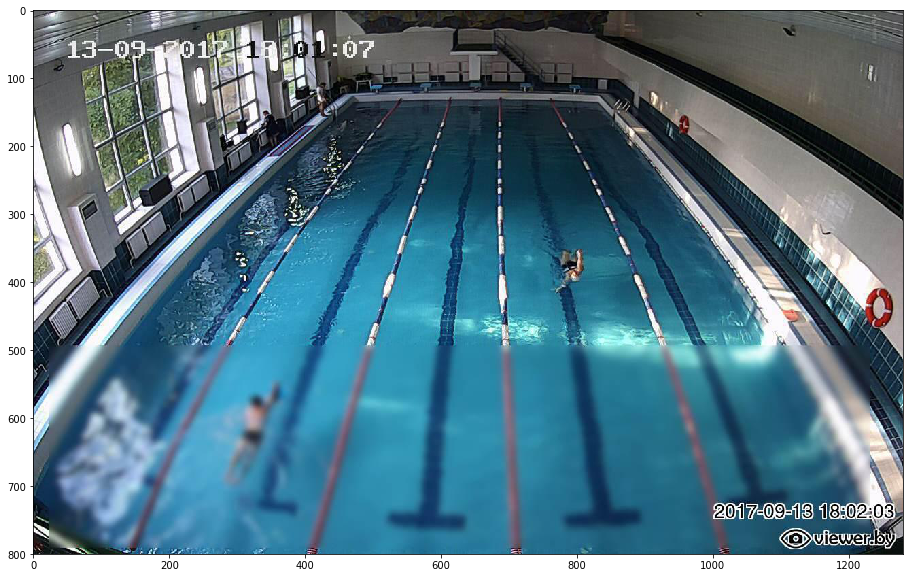

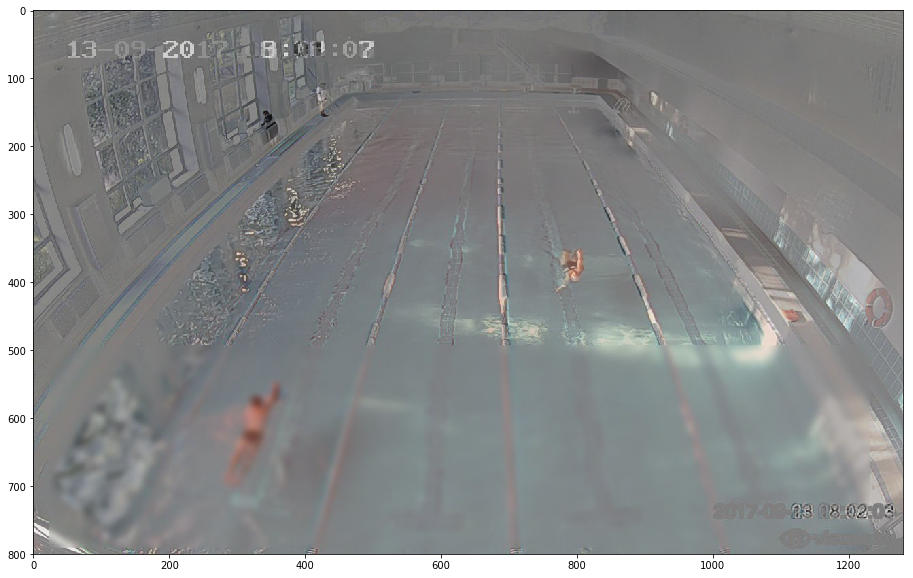

In [14]:
next_img()

# Predict ResNet labels for adjusted images

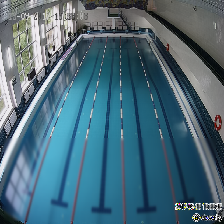

In [90]:
img = Image.fromarray(avg_img.astype(np.uint8).transpose(1,2,0))
img = img.resize((224, 224))
img

In [91]:
avg_img_scaled = np.asarray(img).transpose(2, 0, 1)
avg_img_scaled.shape

(3, 224, 224)

In [80]:
resnet_full = ResNet50(include_top=True)

In [87]:
def predict_img(path):
    img_large = image.load_img(path, target_size=(800, 1280))
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x_alt = x - avg_img_scaled
    x = np.expand_dims(x, axis=0)
    x_alt = np.expand_dims(x_alt, axis=0)
    preds_orig = resnet_full.predict(x)
    preds_alt = resnet_full.predict(x_alt)
    return img_large, decode_predictions(preds_orig, top=20), decode_predictions(preds_alt, top=20)

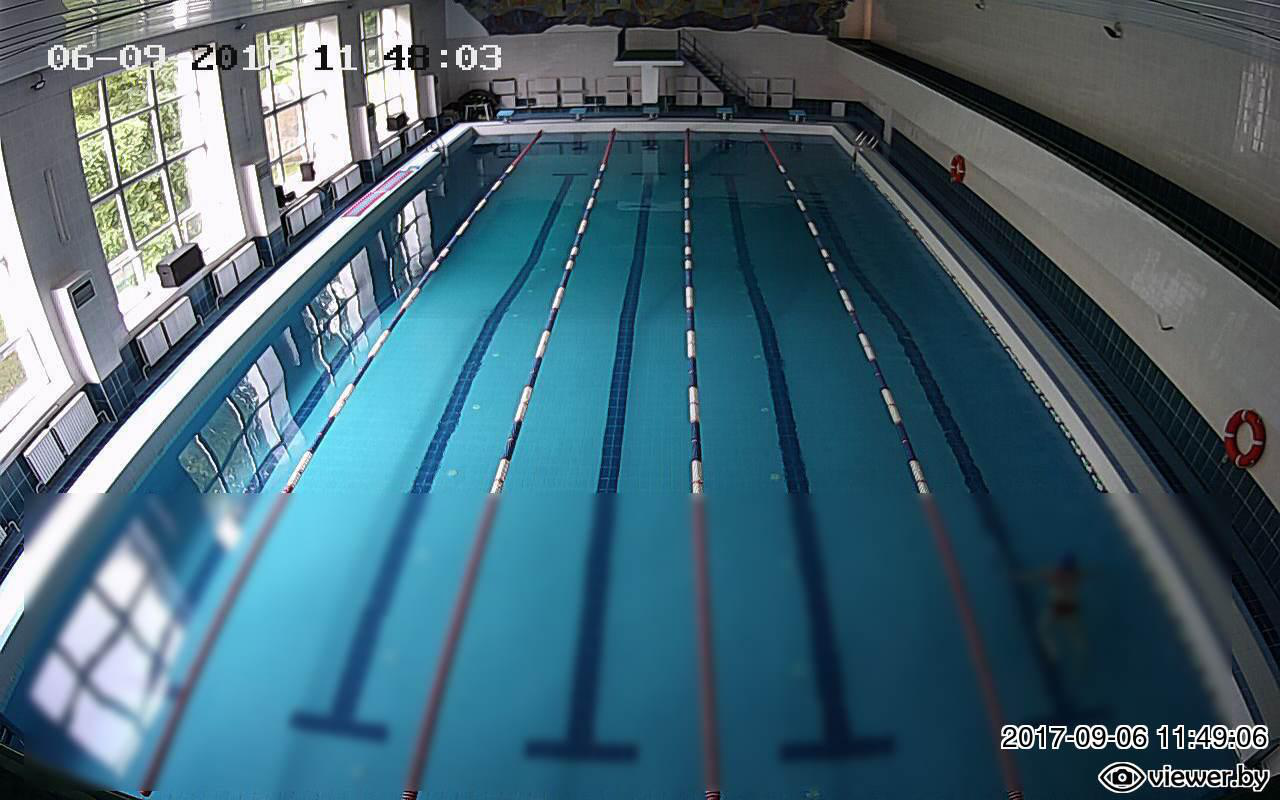

In [88]:
img, preds_orig, preds_alt = predict_img('../data/labeled/imgs/20170906114932.jpg')
img

In [89]:
preds_orig, preds_alt

([[('n03637318', 'lampshade', 0.3884694),
   ('n02930766', 'cab', 0.16176264),
   ('n03388043', 'fountain', 0.068859488),
   ('n02788148', 'bannister', 0.052830499),
   ('n02965783', 'car_mirror', 0.049387209),
   ('n03220513', 'dome', 0.021220047),
   ('n04366367', 'suspension_bridge', 0.019458733),
   ('n03891251', 'park_bench', 0.016094837),
   ('n03854065', 'organ', 0.015518582),
   ('n06874185', 'traffic_light', 0.014627506),
   ('n03452741', 'grand_piano', 0.013374641),
   ('n02871525', 'bookshop', 0.010634894),
   ('n04286575', 'spotlight', 0.0098092388),
   ('n03933933', 'pier', 0.0069037816),
   ('n04557648', 'water_bottle', 0.006389793),
   ('n03028079', 'church', 0.0063004345),
   ('n04589890', 'window_screen', 0.0062772483),
   ('n03126707', 'crane', 0.0054347725),
   ('n04590129', 'window_shade', 0.0051111402),
   ('n07565083', 'menu', 0.0049652811)]],
 [[('n04523525', 'vault', 0.55214763),
   ('n03388043', 'fountain', 0.12086225),
   ('n03788195', 'mosque', 0.069510862),


# Does it imrove prediction errors?

In [ ]:
resnet_model = ResNet50(include_top=False, input_shape=(3, 224, 224))

In [38]:
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname): 
    return bcolz.open(fname)[:]

def sub_average(x):
    return x - avg_img_scaled

def save_resnet_vecs(vec_fname, img_name_fname, folder):
    gen = ImageDataGenerator(preprocessing_function=sub_average)
    batches = gen.flow_from_directory(folder, 
                                      target_size=(224, 224), 
                                      batch_size=64, 
                                      class_mode=None,
                                      shuffle=False)
    vecs = resnet_model.predict_generator(batches, steps=(batches.samples + batches.batch_size) 
                                          // batches.batch_size)
    save_array(vec_fname, vecs)
    save_array(img_name_fname, batches.filenames)
    
def load_resnet_vecs(vec_fname, img_name_fname):
    return load_array(img_name_fname), load_array(vec_fname)

In [41]:
save_resnet_vecs('vecs_avg', 'img_name_avg', '../data/labeled')

Found 200 images belonging to 1 classes.


In [43]:
fnames, vecs = load_resnet_vecs('vecs_avg', 'img_name_avg')
df = pd.read_csv('../data/labels.csv')

labels = np.array([df[df['imgs'] == x[5:]].iat[0, 1] for x in fnames])
np.random.seed(123)
vecs_lin = vecs.reshape(200, 2048)

In [92]:
regr = linear_model.Ridge(alpha = 200)
scores = cross_val_score(regr, vecs_lin, labels, cv=5, scoring='neg_mean_squared_error')
scores, np.mean(scores), np.std(scores)

(array([-2.01504872, -2.21928315, -0.82697863, -2.75102339, -2.09314097]),
 -1.9810949722642643,
 0.63169851730514581)